# STZ Linear Viscoelastic Spectrum (SAOS)

**Shear Transformation Zone model — Small-Amplitude Oscillatory Shear**

## Physical Context: Linear Viscoelastic Regime and Effective Relaxation Time

**Small-amplitude oscillatory shear (SAOS)** probes the linear viscoelastic response of materials by applying a sinusoidal strain $\gamma(t) = \gamma_0 \sin(\omega t)$ with $\gamma_0 \ll 1$. The resulting stress response is measured as storage modulus $G'(\omega)$ (elastic component) and loss modulus $G''(\omega)$ (viscous component). For **amorphous solids** near the glass transition, SAOS reveals the dominant structural relaxation timescale.

### STZ Interpretation: Single-Mode Maxwell Approximation

In the small-strain limit, the full nonlinear STZ equations reduce to a **Maxwell model** with an activation-controlled relaxation time:

$$\tau_{\text{eff}} = \frac{\tau_0}{2 \varepsilon_0 \Lambda_{ss}}$$

where $\Lambda_{ss} = \exp(-e_z / \chi_{\infty})$ is the steady-state STZ density. The dynamic moduli then follow:

$$G'(\omega) = G_0 \frac{(\omega \tau_{\text{eff}})^2}{1 + (\omega \tau_{\text{eff}})^2}, \quad G''(\omega) = G_0 \frac{\omega \tau_{\text{eff}}}{1 + (\omega \tau_{\text{eff}})^2}$$

### Key Physics

1. **Crossover frequency** $\omega_c = 1/\tau_{\text{eff}}$: Marks the transition from elastic-dominated ($\omega \gg \omega_c$, $G' > G''$) to viscous-dominated ($\omega \ll \omega_c$, $G'' > G'$) behavior
2. **Structural relaxation**: The STZ flip rate $1/\tau_0$ is modulated by the STZ density $\Lambda$, giving an effective relaxation time that is exponentially sensitive to disorder ($\chi$)
3. **Limitations**: Real polymer glasses near $T_g$ have a **broad relaxation spectrum** (Kohlrausch-Williams-Watts stretched exponential). The single-mode STZ approximation captures the dominant $\alpha$-relaxation but misses the high-frequency $\beta$-relaxation.

### Materials

This notebook uses **polystyrene at 145°C** — just above its glass transition temperature ($T_g \approx 100$°C). Near $T_g$, polystyrene exhibits glassy dynamics where segmental motion is governed by cooperative rearrangements analogous to STZ events. The SAOS data captures the $\alpha$-relaxation peak in the loss modulus.

> **Handbook:** For detailed STZ SAOS theory, see [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)

## Learning Objectives

- Understand the STZ linear viscoelastic (Maxwell-like) approximation
- Fit $G'(\omega)$ and $G''(\omega)$ from polystyrene oscillation data
- Interpret the effective relaxation time $\tau_{\text{eff}}$ from STZ activation
- Analyze crossover frequency and Cole-Cole representation
- Perform Bayesian inference and assess identifiability of 6 parameters

## Prerequisites

- Notebook 01 (STZ flow curve) for basic STZ concepts
- Understanding of $G'$, $G''$ frequency-domain data

## Estimated Runtime

- Fast demo (1 chain): ~1-2 min
- Full run (4 chains): ~4-6 min

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import gc
import os

# Add examples root to path for shared utilities
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.stz import STZConventional

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Targeted suppression: equinox internal deprecation (harmless, not under our control)
warnings.filterwarnings("ignore", message=".*is_leaf.*", category=DeprecationWarning)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: SAOS from STZ Activation

In the **linear viscoelastic limit** (small strain amplitude), the STZ model reduces to a **Maxwell model** with an effective relaxation time determined by STZ activation.

At steady state, $\chi \to \chi_{\infty}$ and the STZ density is:

$$\Lambda_{\text{ss}} = \exp(-e_z / \chi_{\infty})$$

The effective Maxwell relaxation time is:

$$\tau_{\text{eff}} = \frac{\tau_0}{2 \epsilon_0 \Lambda_{\text{ss}}}$$

The dynamic moduli then follow:

$$G'(\omega) = G_0 \frac{(\omega \tau_{\text{eff}})^2}{1 + (\omega \tau_{\text{eff}})^2}$$

$$G''(\omega) = G_0 \frac{\omega \tau_{\text{eff}}}{1 + (\omega \tau_{\text{eff}})^2}$$

### Parameters for SAOS (6 total)

| Parameter | Role in SAOS |
|-----------|-------------|
| G0 | Sets the high-frequency plateau modulus |
| sigma_y | Enters indirectly (not strongly constrained by SAOS) |
| chi_inf | Controls Lambda_ss and thus tau_eff |
| tau0 | Attempt time — sets absolute timescale |
| epsilon0 | Strain increment — scales tau_eff |
| ez | Formation energy — exponentially controls Lambda_ss |

**Limitation:** This is a single-relaxation-time approximation. Real polymers near T_g have a broad spectrum, so deviations from single-Maxwell behavior are expected.

### Material-Model Compatibility

We use **polystyrene at 145 C** — close to its glass transition temperature ($T_g \approx 100$ C). Near $T_g$, polystyrene is an amorphous solid where relaxation is governed by cooperative segmental motions analogous to STZ rearrangements. The single-Maxwell approximation captures the dominant relaxation mode but will miss the high-frequency wing from faster local motions.

## 3. Load Data

In [3]:
# Robust path resolution for execution from any directory
import sys
from pathlib import Path

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_stz_candidates = [_nb_dir, Path("examples/stz"), _nb_dir.parent / "stz"]
for _p in _stz_candidates:
    if (_p / "stz_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break

from stz_tutorial_utils import load_polystyrene_oscillation

omega, G_prime, G_double_prime = load_polystyrene_oscillation(temp=145)

print(f"Data points: {len(omega)}")
print(f"Frequency range: {omega.min():.1f} - {omega.max():.1f} rad/s")
print(f"G' range: {G_prime.min():.0f} - {G_prime.max():.0f} Pa")
print(f"G'' range: {G_double_prime.min():.0f} - {G_double_prime.max():.0f} Pa")

Data points: 32
Frequency range: 0.0 - 300.0 rad/s
G' range: 30467 - 597000 Pa
G'' range: 26961 - 617000 Pa


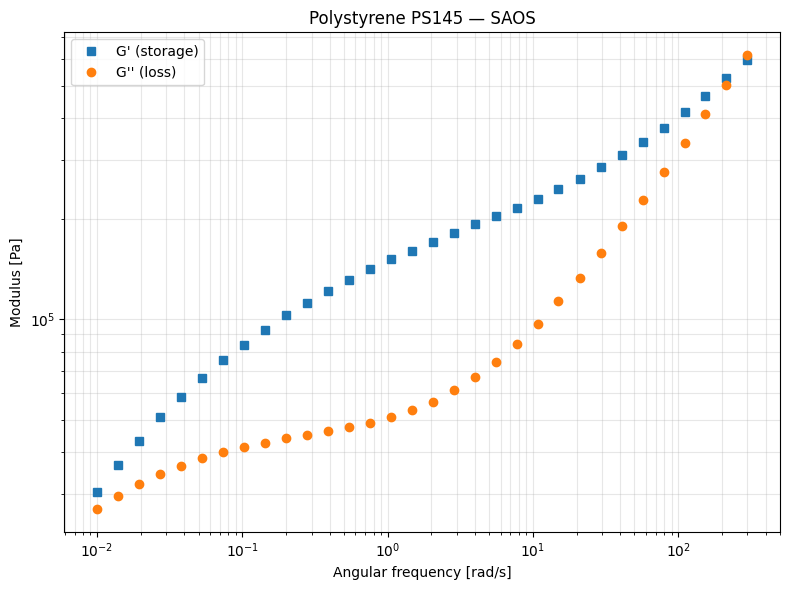

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(omega, G_prime, "s", markersize=6, color="C0", label="G' (storage)")
ax.loglog(omega, G_double_prime, "o", markersize=6, color="C1", label="G'' (loss)")
ax.set_xlabel("Angular frequency [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Polystyrene PS145 — SAOS")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
from stz_tutorial_utils import compute_fit_quality

# Prepare y data: interleaved [G', G''] as expected by the model
G_star = np.column_stack([G_prime, G_double_prime])

model = STZConventional(variant="standard")

# Set bounds BEFORE values — use set_bounds() to update both bounds and constraints
model.parameters.set_bounds("G0", (1e4, 1e8))
model.parameters["G0"].value = 1e6
model.parameters.set_bounds("sigma_y", (1e3, 1e8))
model.parameters["sigma_y"].value = 1e5
model.parameters.set_bounds("chi_inf", (0.02, 0.5))
model.parameters["chi_inf"].value = 0.15
model.parameters.set_bounds("tau0", (1e-12, 1e0))
model.parameters["tau0"].value = 1e-6
model.parameters.set_bounds("epsilon0", (0.01, 1.0))
model.parameters["epsilon0"].value = 0.1
model.parameters.set_bounds("ez", (0.1, 5.0))
model.parameters["ez"].value = 1.0

t0 = time.time()
model.fit(omega, G_star, test_mode="oscillation", use_log_residuals=True)
t_nlsq = time.time() - t0

# Compute fit quality for G' and G'' combined
G_pred_at_data = model.predict(omega)
G_all_data = np.concatenate([G_prime, G_double_prime])
G_all_pred = np.concatenate([G_pred_at_data[:, 0], G_pred_at_data[:, 1]])
quality = compute_fit_quality(G_all_data, G_all_pred)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R-squared: {quality['r_squared']:.6f}")
print(f"RMSE: {quality['rmse']:.1f} Pa")
print("\nFitted parameters:")
saos_params = ["G0", "sigma_y", "chi_inf", "tau0", "epsilon0", "ez"]
for name in saos_params:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.301120s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=2.7260 | elapsed=2.301s | final_gradient_norm=0.6268


NLSQ fit time: 2.76 s
R-squared: -0.200647
RMSE: 164560.3 Pa

Fitted parameters:
  G0         = 1.791e+05
  sigma_y    = 2.985e+06
  chi_inf    = 0.1497
  tau0       = 0.002349
  epsilon0   = 0.09979
  ez         = 1.009


### 4.1 Fit Quality and Crossover Analysis

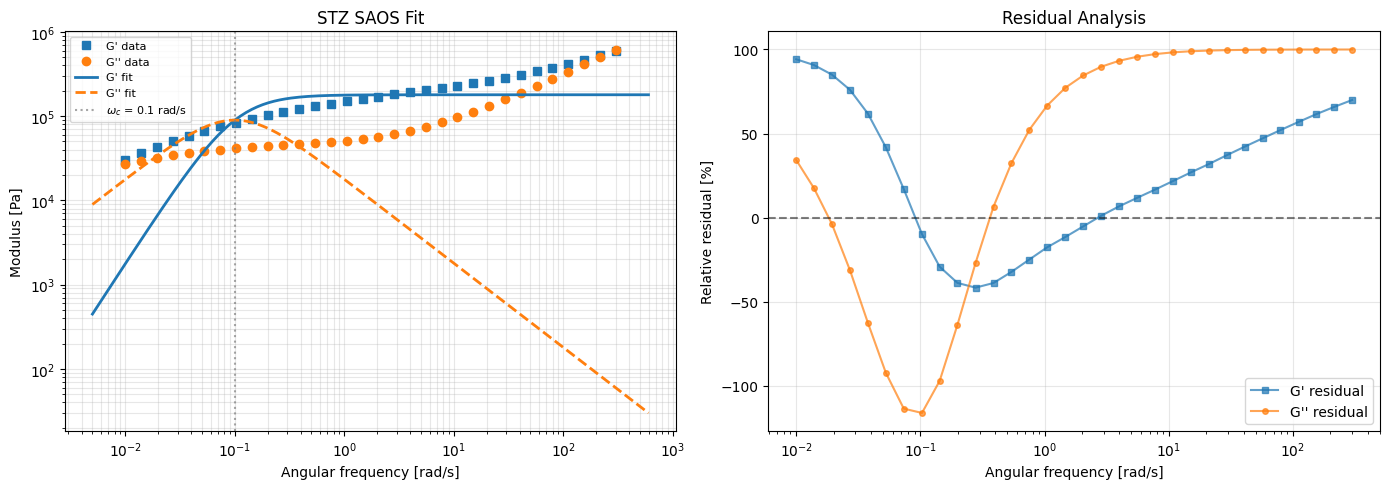


Effective relaxation time: tau_eff = 9.981 s
Crossover frequency: omega_c = 0.1002 rad/s
Lambda_ss = exp(-ez/chi_inf) = 0.001179


In [6]:
omega_fine = np.logspace(
    np.log10(omega.min()) - 0.3,
    np.log10(omega.max()) + 0.3,
    200,
)
G_pred = model.predict(omega_fine)
G_prime_pred = G_pred[:, 0]
G_double_prime_pred = G_pred[:, 1]

# Find crossover frequency
chi_inf_fit = model.parameters.get_value("chi_inf")
ez_fit = model.parameters.get_value("ez")
tau0_fit = model.parameters.get_value("tau0")
eps0_fit = model.parameters.get_value("epsilon0")
Lambda_ss = np.exp(-ez_fit / chi_inf_fit)
tau_eff = tau0_fit / (2.0 * eps0_fit * Lambda_ss)
omega_c = 1.0 / tau_eff

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: G', G'' fit
ax1.loglog(omega, G_prime, "s", markersize=6, color="C0", label="G' data")
ax1.loglog(omega, G_double_prime, "o", markersize=6, color="C1", label="G'' data")
ax1.loglog(omega_fine, G_prime_pred, "-", lw=2, color="C0", label="G' fit")
ax1.loglog(omega_fine, G_double_prime_pred, "--", lw=2, color="C1", label="G'' fit")
ax1.axvline(omega_c, color="gray", linestyle=":", alpha=0.7, label=f"$\\omega_c$ = {omega_c:.2g} rad/s")
ax1.set_xlabel("Angular frequency [rad/s]")
ax1.set_ylabel("Modulus [Pa]")
ax1.set_title("STZ SAOS Fit")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

# Right: residuals
G_pred_at_data = model.predict(omega)
res_Gp = (G_prime - G_pred_at_data[:, 0]) / G_prime * 100
res_Gpp = (G_double_prime - G_pred_at_data[:, 1]) / G_double_prime * 100

ax2.semilogx(omega, res_Gp, "s-", markersize=4, alpha=0.7, label="G' residual")
ax2.semilogx(omega, res_Gpp, "o-", markersize=4, alpha=0.7, label="G'' residual")
ax2.axhline(0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Angular frequency [rad/s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residual Analysis")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nEffective relaxation time: tau_eff = {tau_eff:.4g} s")
print(f"Crossover frequency: omega_c = {omega_c:.4g} rad/s")
print(f"Lambda_ss = exp(-ez/chi_inf) = {Lambda_ss:.4g}")

### 4.2 Cole-Cole Plot

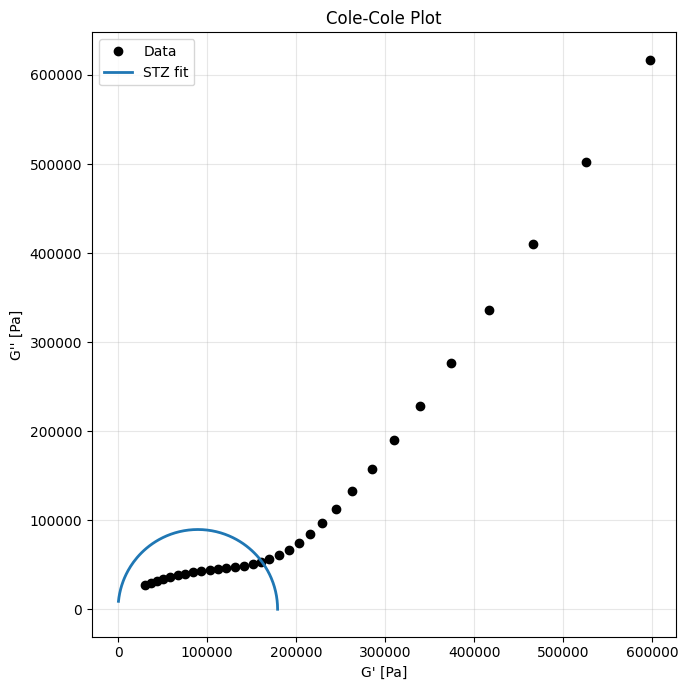

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(G_prime, G_double_prime, "ko", markersize=6, label="Data")
ax.plot(G_prime_pred, G_double_prime_pred, "-", lw=2, color="C0", label="STZ fit")
ax.set_xlabel("G' [Pa]")
ax.set_ylabel("G'' [Pa]")
ax.set_title("Cole-Cole Plot")
ax.set_aspect("equal")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

A single Maxwell element produces a perfect semicircle in Cole-Cole space. Deviations indicate the need for a broader relaxation spectrum (e.g., Generalized Maxwell / KWW), which STZ's single-mode approximation cannot capture.

## 5. Bayesian Inference

### 5.1 Run NUTS

In [8]:
initial_values = {
    name: model.parameters.get_value(name)
    for name in model.parameters.keys()
}

# Free memory before Bayesian inference
gc.collect()
jax.clear_caches()

if FAST_MODE:
    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 50, 100, 1
else:
    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 1000, 2000, 4

t0 = time.time()
result = model.fit_bayesian(
    omega,
    G_star,
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"Bayesian inference time: {t_bayes:.1f} s")

  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<02:27,  1.01it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

sample:  46%|████▌     | 69/150 [00:01<00:00, 86.55it/s, 31 steps of size 9.04e-02. acc. prob=0.93]

sample: 100%|██████████| 150/150 [00:01<00:00, 130.79it/s, 63 steps of size 9.04e-02. acc. prob=0.84]

Bayesian inference time: 3.6 s


### 5.2 Convergence Diagnostics

In [9]:
from stz_tutorial_utils import print_convergence_summary

print_convergence_summary(result, saos_params)

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
--------------------------------------------------
          G0    0.9955        93     CHECK
     sigma_y    0.9935        68     CHECK
     chi_inf    1.0466        52     CHECK
        tau0    1.0008        41     CHECK
    epsilon0    1.0006        59     CHECK
          ez    1.0175        34     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


False

### 5.3 ArviZ Plots

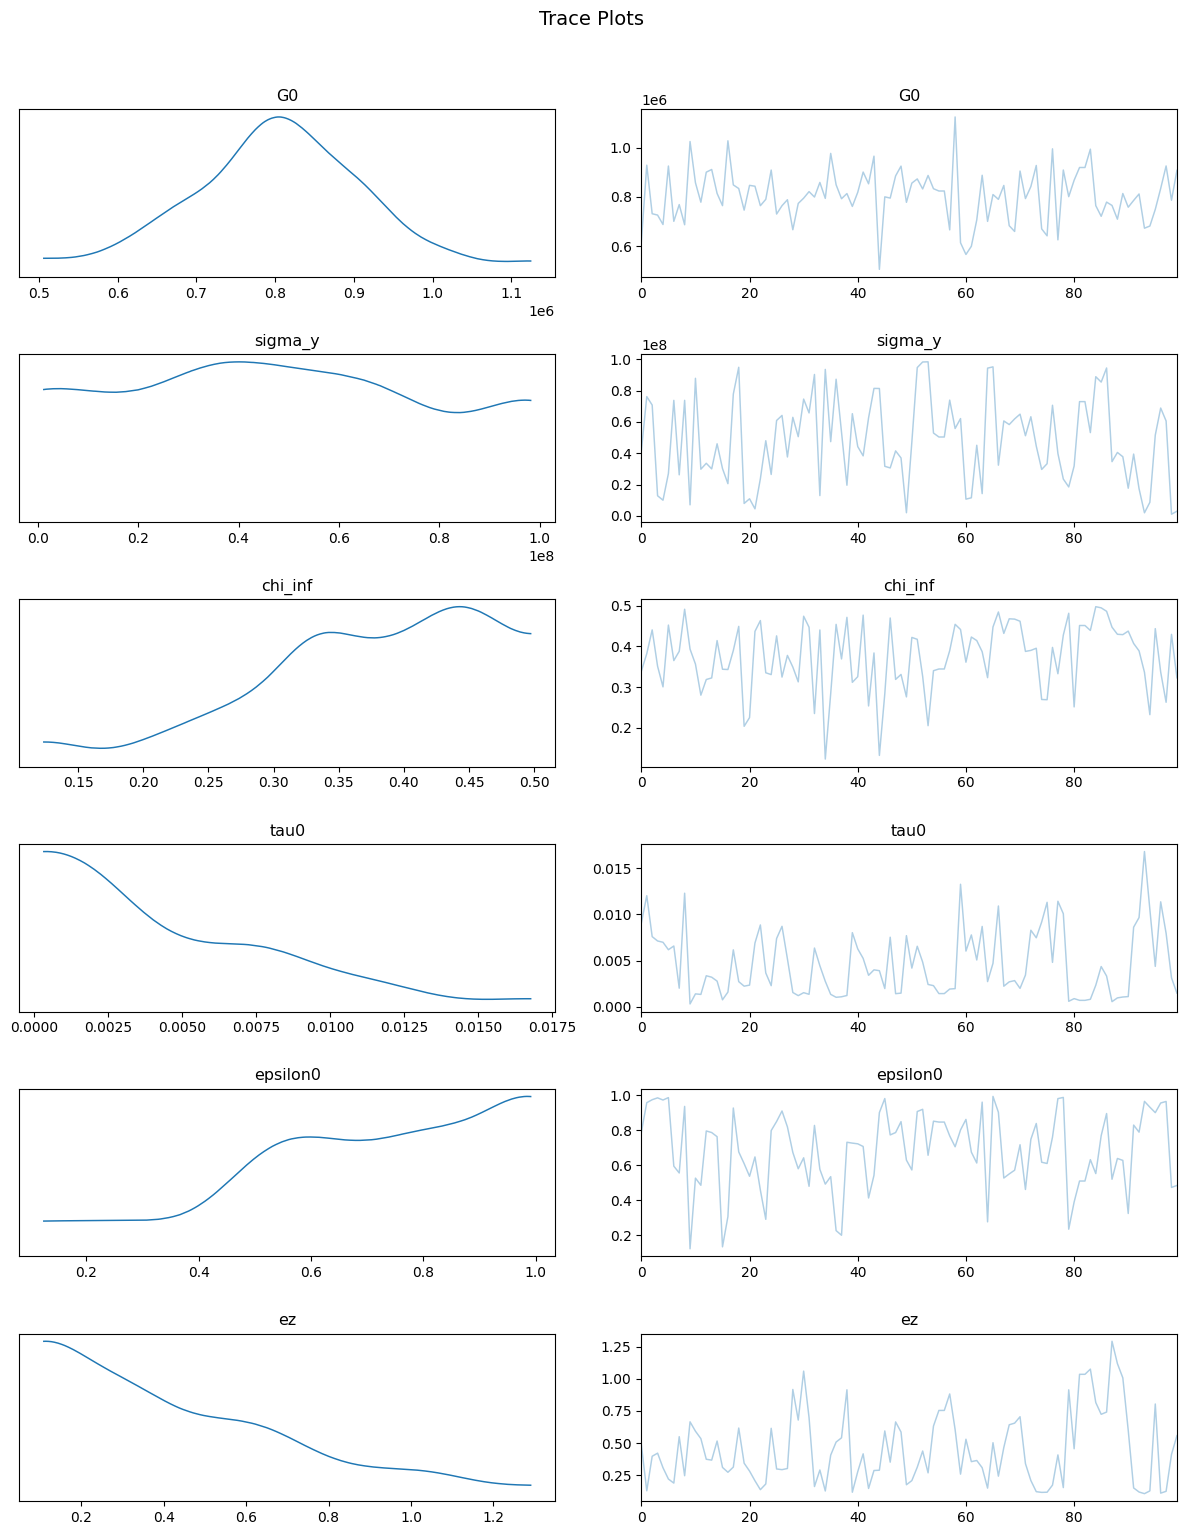

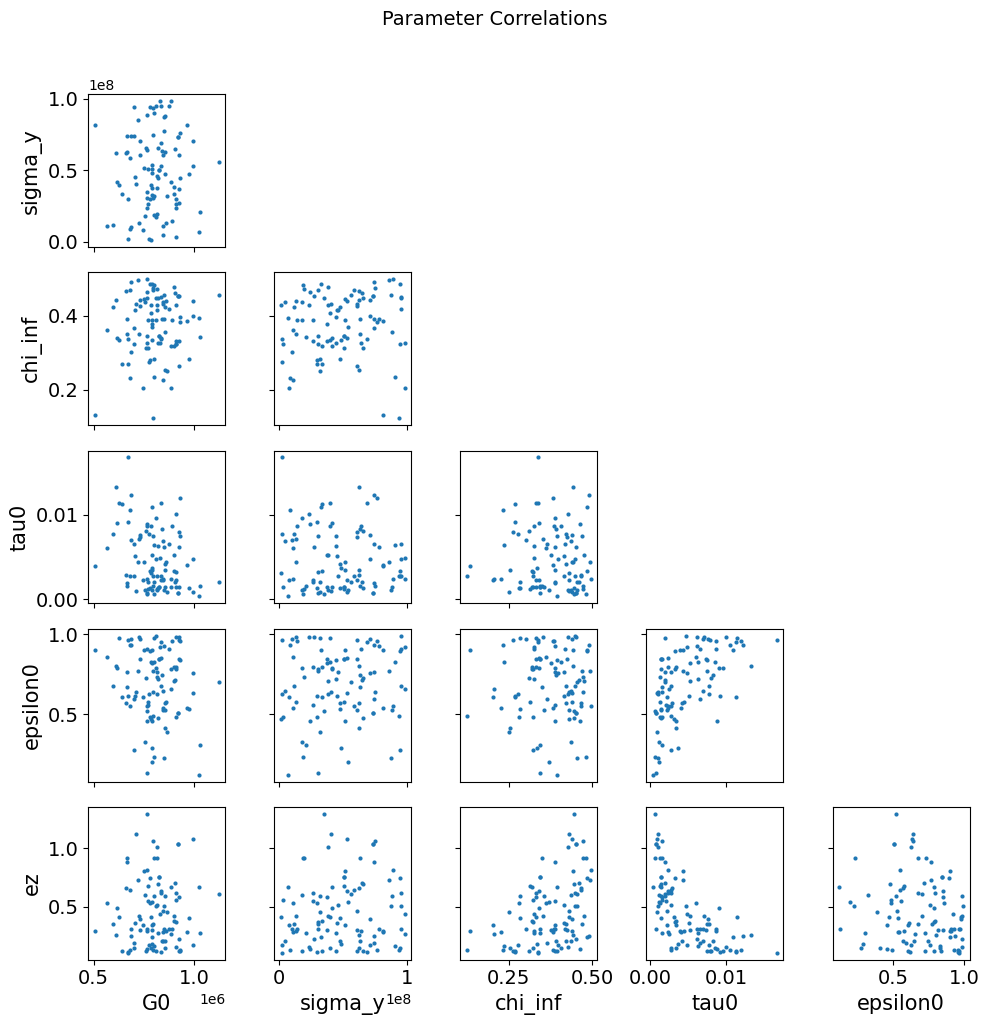

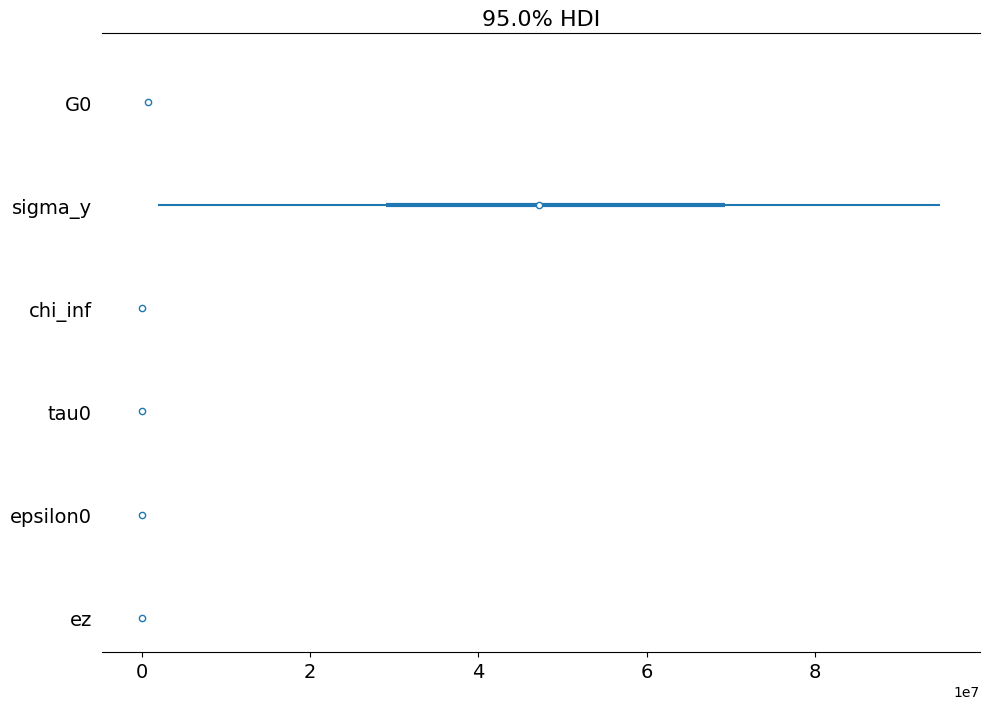

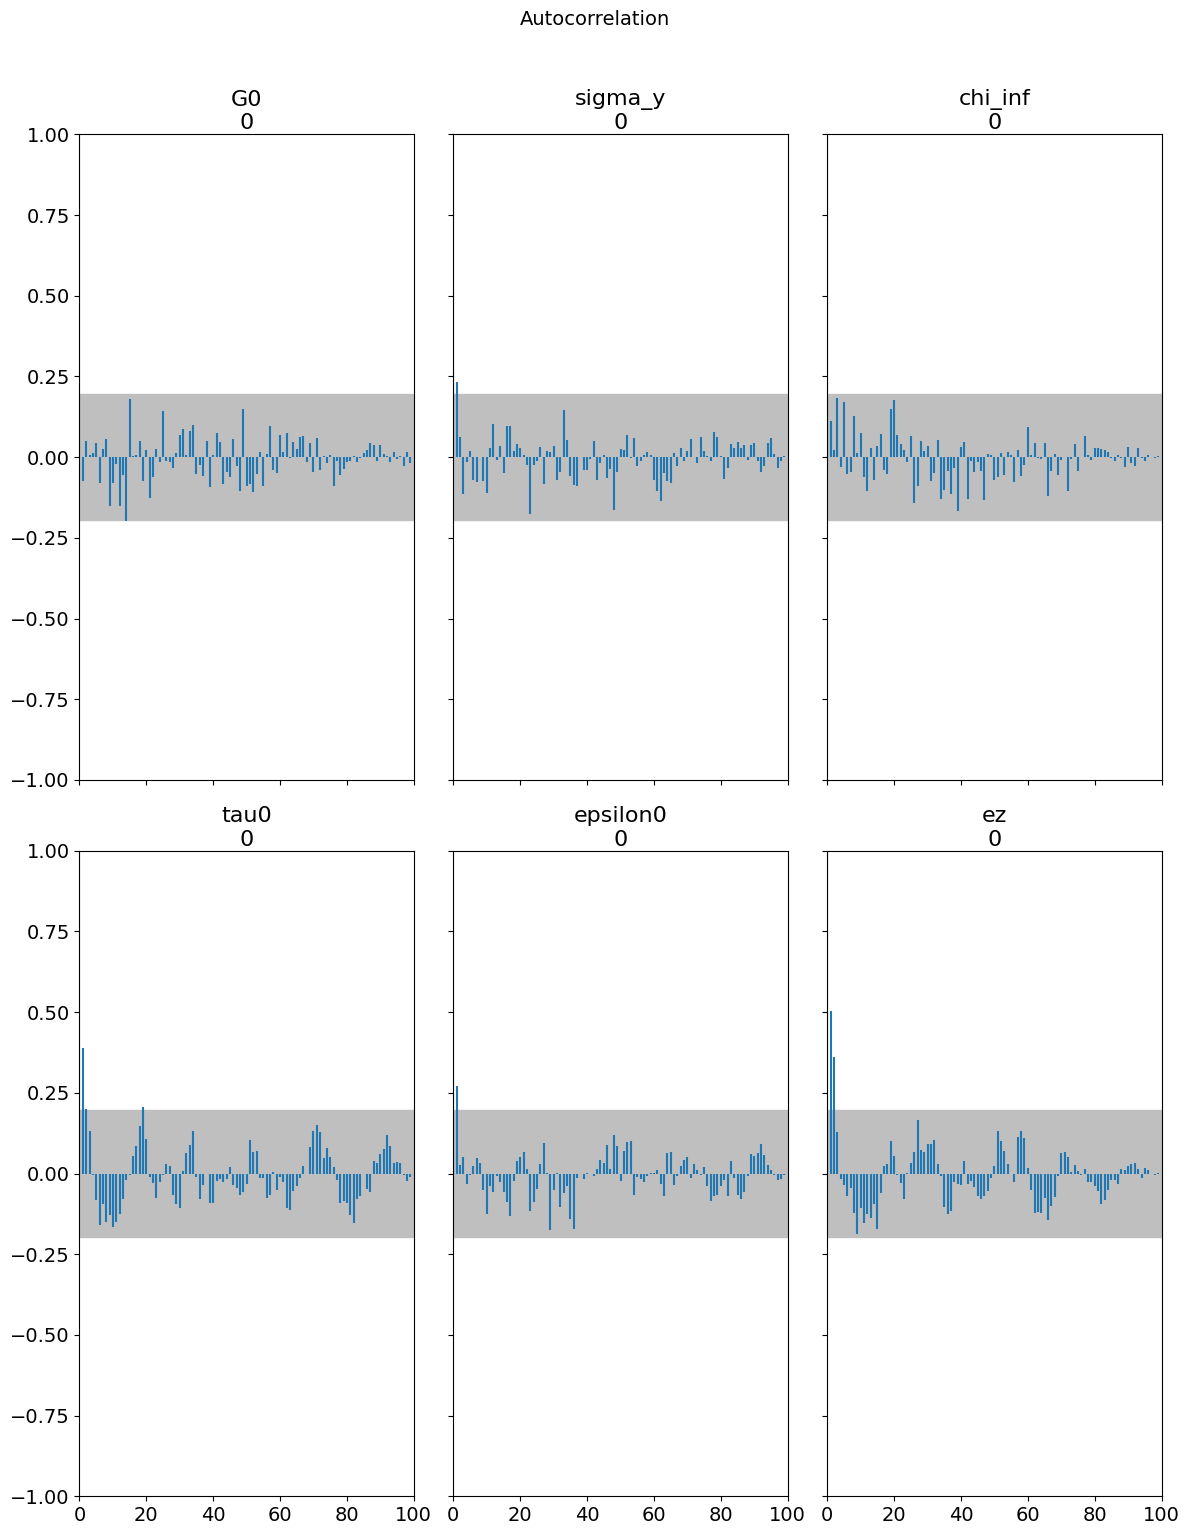

In [10]:
display_arviz_diagnostics(result, saos_params, fast_mode=FAST_MODE)

### 5.4 Parameter Summary

In [11]:
from stz_tutorial_utils import print_parameter_comparison

posterior = result.posterior_samples
print_parameter_comparison(model, posterior, saos_params)


Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ        Median                    95% CI
-----------------------------------------------------------------
          G0     1.791e+05     8.006e+05  [6.061e+05, 1.011e+06]
     sigma_y     2.985e+06     4.724e+07  [2.472e+06, 9.499e+07]
     chi_inf        0.1497         0.388  [0.2046, 0.489]
        tau0      0.002349      0.003419  [0.0006456, 0.01215]
    epsilon0       0.09979        0.7115  [0.2131, 0.9845]
          ez         1.009        0.3867  [0.1183, 1.068]


### 5.5 Posterior Predictive Check

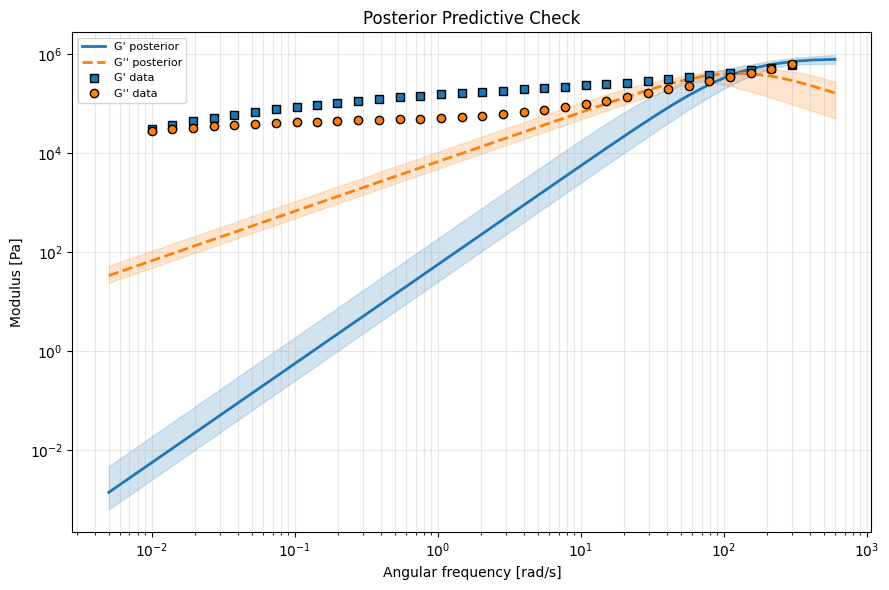

In [12]:
n_draws = min(50 if FAST_MODE else 200, len(list(posterior.values())[0]))
omega_pred = np.logspace(
    np.log10(omega.min()) - 0.3,
    np.log10(omega.max()) + 0.3,
    100,
)
omega_pred_jax = jnp.asarray(omega_pred, dtype=jnp.float64)

Gp_samples = []
Gpp_samples = []
for i in range(n_draws):
    pred_i = STZConventional._predict_saos_jit(
        omega_pred_jax,
        posterior["G0"][i],
        posterior["sigma_y"][i],
        posterior["chi_inf"][i],
        posterior["tau0"][i],
        posterior["epsilon0"][i],
        posterior["ez"][i],
    )
    pred_arr = np.array(pred_i)
    Gp_samples.append(pred_arr[:, 0])
    Gpp_samples.append(pred_arr[:, 1])

Gp_samples = np.array(Gp_samples)
Gpp_samples = np.array(Gpp_samples)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(omega_pred,
    np.percentile(Gp_samples, 2.5, axis=0),
    np.percentile(Gp_samples, 97.5, axis=0),
    alpha=0.2, color="C0")
ax.fill_between(omega_pred,
    np.percentile(Gpp_samples, 2.5, axis=0),
    np.percentile(Gpp_samples, 97.5, axis=0),
    alpha=0.2, color="C1")
ax.loglog(omega_pred, np.median(Gp_samples, axis=0), "-", lw=2, color="C0", label="G' posterior")
ax.loglog(omega_pred, np.median(Gpp_samples, axis=0), "--", lw=2, color="C1", label="G'' posterior")
ax.loglog(omega, G_prime, "s", markersize=6, color="C0", markeredgecolor="k", label="G' data")
ax.loglog(omega, G_double_prime, "o", markersize=6, color="C1", markeredgecolor="k", label="G'' data")
ax.set_xlabel("Angular frequency [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Limitations

The STZ SAOS prediction is a **single Maxwell mode** approximation:

- It captures the **dominant relaxation** around the crossover frequency
- It **underestimates G''** at high frequencies (fast beta-relaxation modes not included)
- It **overestimates G'** at low frequencies if the terminal zone hasn't been reached
- For broad spectra, use the Generalized Maxwell model instead

Despite these limitations, the SAOS fit provides valuable estimates of G0 and tau_eff that are physically meaningful within the STZ framework.

## 7. Save Results

In [13]:
from stz_tutorial_utils import save_stz_results

output_dir = os.path.join("..", "outputs", "stz", "saos")
save_stz_results(model, result, output_dir, "saos")

Results saved to ../outputs/stz/saos/
  nlsq_params_saos.json: 8 parameters
  posterior_saos.json: 100 draws


## Key Takeaways

1. **STZ SAOS = Maxwell with activation-controlled relaxation time** — $\tau_{\text{eff}} = \tau_0 / (2 \varepsilon_0 \Lambda_{ss})$
2. **$\Lambda_{ss} = \exp(-e_z/\chi_{\infty})$** links structural disorder to relaxation dynamics
3. **6 parameters** are needed for SAOS, vs 4 for the flow curve — $\varepsilon_0$ and $G_0$ become identifiable
4. **Single-mode limitation** — deviations from the semicircular Cole-Cole arc indicate spectral broadening
5. **Crossover frequency $\omega_c = 1/\tau_{\text{eff}}$** gives the characteristic relaxation rate of the amorphous solid

## Next Steps

- **Notebook 02**: Startup shear with stress overshoot (requires ODE integration, all 8 parameters)
- **Notebook 06**: LAOS for nonlinear oscillatory response

## Further Reading

- [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)
- Falk, M.L. & Langer, J.S. (1998). Dynamics of viscoplastic deformation in amorphous solids. *Phys. Rev. E*, 57, 7192–7205.
- Langer, J.S. (2008). Shear-transformation-zone theory of plastic deformation near the glass transition. *Phys. Rev. E*, 77, 021502.
- Rottler, J. & Robbins, M.O. (2003). Shear yielding of amorphous glassy solids: Effect of temperature and strain rate. *Phys. Rev. E*, 68, 011507.